<a href="https://colab.research.google.com/github/priyaskr13/AutomateIdentificationOfTextFromImage/blob/main/PRIYA_S_Automate_identification_and_recognition_of_handwritten_text_from_an_image_TCS_iON_RIO_210.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automate Identification And Recognition Of Handwritten Text from An Image.**
(Using Convolutional Recurrent Neural Network)



---


**Name of The Student :** PRIYA S

**Internship Project Topic :** Automate identification and recognition of handwritten text from an image

**Name of the Organization :**  TCS iON

**Name of the Industry Mentor :** Himdweep Walia

**Name of the Institute :** SRM University, Tamilnadu

---

**Introduction**

The project is based on extracting text, the text can be handwritten, or it can machine printed text and convert it into computer understandable or computer editable format. It is based on enhancement of OCR system. Optical character recognition, deals with the extraction of editable text content from text that appears inside images (for example, in a photo of a road sign, or a scanned document). An optical character recognition problem is basically a type of image-based sequence recognition problem. Most suitable algorithm for sequence recognition problem is RNN (Recurrent Neural Network) and for image-based problem is CNN (convolution neural network). To implement OCR in the project we need to combine both CNN and RNN, that is CRNN(Convolutional recurrent neural network).

**Steps to implement the CRNN is as follows: **
1.	Setting Up Kaggle
2.	Collecting Dataset
3.	Processing Data
4.	Creating Network Architecture
5.	Defining Loss Function
6.	Training Model
7.	Testing and Prediction
8. Plot Accuracy and Loss
9. Get Best Model Index
10. Save Model


## **Setting Up Kaggle in Google Colab**
Kaggle is an online community platform, we are using it is an optional method to save the dataset. So that we can load the dataset in an efficient way than to Google drive. Kaggle takes half the time as compared to google drive to train the model. In order to use Kaggle I created an account in the platform.  Steps involved in setting up Kaggle are listed below.
1.	Install Kaggle.
2.	Create token.
3.	Create Folder.
4.	Get API link and download dataset.
5.	Unzip the File.


## **Installing Kaggle to use kaggle dataset on Google Colab.**

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Collecting Dataset**

Using IAM database dataset for training and testing the model. It contains about 1GB of data (worth images) as zip file.

Link to download dataset : https://fki.tic.heia-fr.ch/databases/iam-handwriting-database


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"priyaskr","key":"e1151e44517e4923a6e1c13e574e7cd6"}'}

## **Create folder to store kaggle dataset on colab**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

## **Copy the API link and paste with '!' to download the datset**

In [ ]:
!kaggle datasets download -d priyaskr/worddataset

100% 1.10G/1.10G [00:37<00:00, 40.0MB/s]
100% 1.10G/1.10G [00:37<00:00, 31.7MB/s]


## **Unzip the file**

In [ ]:
from zipfile import ZipFile
filename="worddataset.zip"
with ZipFile(filename,"r") as zip:
  zip.extractall()
  print("done")

done


## **Importing necessary packages**

## **Installing Keras_tqdm**

In [ ]:
!pip install keras_tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install keras.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2655 sha256=2b2f2613686432d5f7473f6e6238b79adddb29c923c4e3ded7944ea26d873279
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

import os
from google.colab import drive #To use googel drive to get files.

from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional,Dropout
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
#from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## **Tensorflow GPU**


We used Google Colab GPU

In [ ]:
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17152229110986739198
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4543921530204300446
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



## **checking GPU availability**

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

## **Preprocessing**

To train the model using the dataset we should preprocess the dataset. To preprocess the input image output lables, first Read the image and converting it to a grey scale image using the function
process_image(img)- this functions converts the image of size (32 128, 1) checks with each image and converts it the required size if need. And then adds the padding so that it will be compatible with the input shape. And then normalizing the image by dividing it with 255 to get the better resolution / contrast in image.

Computing the maximum length from words and pad every output label to make it of the same size as the maximum length. This is done to make it compatible with the output shape of our RNN architecture.

To preprocess the output labels, should read the text from the words.txt file. This file contains the text written inside the image in same order and the format is 'a01-000u-00-00 ok 154 408 768 27 51 AT A' like this for all the images.


## **Loading words.txt file from the drive**

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
with open("gdrive/My Drive/words.txt") as f:
  contents=f.readlines()
lines=[line.strip() for line in contents]
lines[0]

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [ ]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))

    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [ ]:
images = []
labels = []
RECORDS_COUNT = 10000

In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [ ]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    # Normalize
    img = img / 255

    return img

## **Generate Train and Validation set**

Here we are using kaggle dataset. Which is unziped file of words.tgz

In [ ]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])

        splits_id = word_id.split('-')

        filepath = 'words/{}/{}-{}/{}.png'.format(splits_id[0],
                                                  splits_id[0],
                                                  splits_id[1],
                                                  word_id)

        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        # processing on label
        try:
            label = encode_to_labels(word)
        except:
            continue

        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)

    if index >= RECORDS_COUNT:
        break

In [ ]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

In [ ]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

## **Convert to numpy array**
*   images = np.asarray(images)
*   inputs_length = np.asarray(inputs_length)
*   labels_length = np.asarray(labels_length)



In [ ]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [ ]:
train_images.shape

(7850, 32, 128, 1)

## **Build Model (Network Archtecture)**
(Using Convolutional Recurrent Neural Network)

This network architecture is inspired by this paper. Let’s see the steps that we used to create the architecture:

Input shape for the architecture having an input image of height 128 and width 32
Building model using Conventional Recurrent Neural Network. Image input size is height 32 and width 128. There are 7 conventional layers used here for the model. In which 6 layers are having the kernel size of (3,3) and last has (2,2).
The filters used in the conventional layers are increased from 64 to 512. Then two max-pooling layers of size (2,1) are added to extract features with a larger width to predict long texts.
We have done normalization layers after fifth and sixth conventional layers. The training process is continued by using the lambda function to squeeze the output. After getting the summery using act_model.summary().


In [ ]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

## **Loss Function**

A CTC loss function requires four arguments to compute the loss, predicted outputs, ground truth labels, input sequence length to LSTM and ground truth label length. To get this we need to create a custom loss function and then pass it to the model. To make it compatible with our model, we will create a model which takes these four inputs and outputs the loss. This model will be used for training and for testing we will use the model that we have created earlier “act_model”.


In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

## **Train the Model**

To train the model use Adam optimizer, Keras callbacks functionality can also be used to save the weights of the best model on the basis of validation loss. In model.compile(), you can see that I have only taken y_pred and neglected y_true. This is because I have already taken labels as input to the model earlier. labels as input to the model earlier. I have used 50 epochs to train the model. The model will be saved in given path. filepath="gdrive/My Drive/Handwritten_Model/{}o-{}r-{}e-{}t-{}v.hdf5"
Training the model using model.fit() function. This will save the model in the filepath given. After that act_model.load_weights(filepath) function will load the data in to the file.


In [ ]:
batch_size = 8
epochs = 50
e = str(epochs)
optimizer_name = 'sgd'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])


filepath="gdrive/My Drive/Handwritten_text_project_model/{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/50

Epoch 1: val_loss improved from inf to 15.86540, saving model to gdrive/My Drive/Handwritten_text_project_model/sgdo-10000r-50e-7850t-876v.hdf5
982/982 - 52s - loss: 15.7210 - accuracy: 0.0000e+00 - val_loss: 15.8654 - val_accuracy: 0.0000e+00 - 52s/epoch - 53ms/step
Epoch 2/50

Epoch 2: val_loss improved from 15.86540 to 15.17352, saving model to gdrive/My Drive/Handwritten_text_project_model/sgdo-10000r-50e-7850t-876v.hdf5
982/982 - 31s - loss: 13.0797 - accuracy: 0.0096 - val_loss: 15.1735 - val_accuracy: 0.0468 - 31s/epoch - 32ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 15.17352
982/982 - 31s - loss: 11.3002 - accuracy: 0.0534 - val_loss: 20.7373 - val_accuracy: 0.0263 - 31s/epoch - 32ms/step
Epoch 4/50

Epoch 4: val_loss improved from 15.17352 to 14.22397, saving model to gdrive/My Drive/Handwritten_text_project_model/sgdo-10000r-50e-7850t-876v.hdf5
982/982 - 31s - loss: 9.4902 - accuracy: 0.0850 - val_loss: 14.2240 - val_accuracy: 0.0525 - 31s/epoch - 3

## **Testing the Model**
Our model is trained with 7850 images. Now it’s time to test the model. We cannot use our training model because it also requires labels as input and at test time, we cannot have labels. So to test the model we will use ”act_model ” that we have created earlier which takes only one input: test images.
As our model predicts the probability for each class at each time step, we need to use some transcription function to convert it into actual texts. Here we used the CTC decoder to get the output text. We use Jaro Distance & Ratio method to test accuracy.

In [ ]:
!pip install python-levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 14.4 MB/s 
     |████████████████████████████████| 2.2 MB 61.3 MB/s 


In [ ]:
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

28/28 [==============================] - 3s 32ms/step
jaro : 0.9230544226406107
ratio: 0.89540666073741


## **Prediction**

2/2 [==============================] - 0s 304ms/step
original_text =  policy
predicted_text = policy

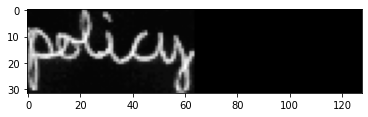



original_text =  of
predicted_text = of

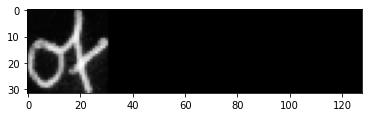



original_text =  change
predicted_text = change

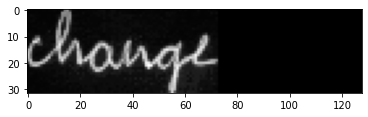



original_text =  Delegates
predicted_text = Delegates

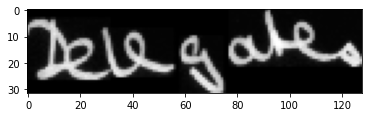



original_text =  from
predicted_text = from

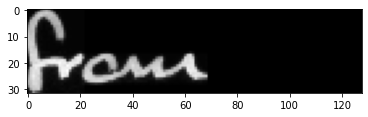



original_text =  Mr.
predicted_text = Mr.

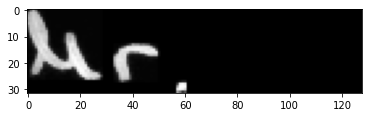



original_text =  Kenneth
predicted_text = Kenneth

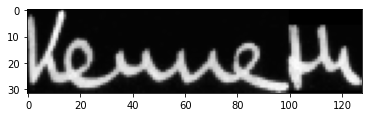



original_text =  Kaunda's
predicted_text = Kaunda's

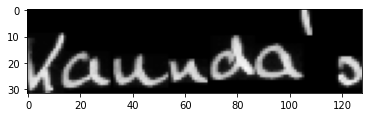



original_text =  United
predicted_text = United

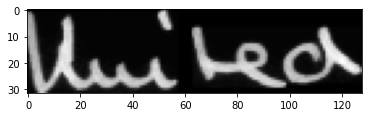



original_text =  National
predicted_text = National

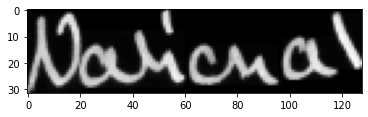



original_text =  Independence
predicted_text = Independence

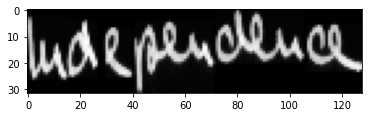



original_text =  Party
predicted_text = Party

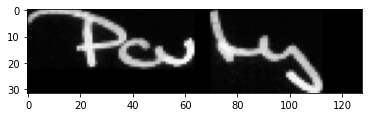



original_text =  280,000
predicted_text = 280,000

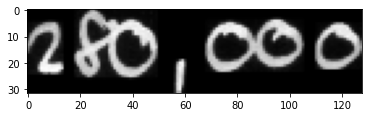



original_text =  members
predicted_text = members

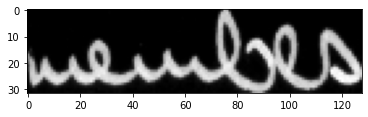



original_text =  )
predicted_text = )

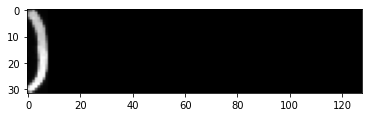



original_text =  and
predicted_text = and

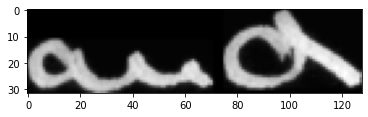



original_text =  Mr.
predicted_text = Mr.

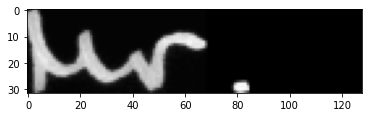



original_text =  Harry
predicted_text = Harry

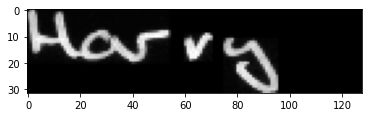



original_text =  Nkumbula's
predicted_text = Nkumbula's

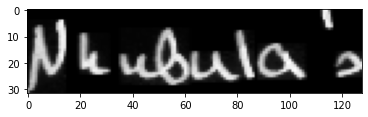



original_text =  African
predicted_text = African

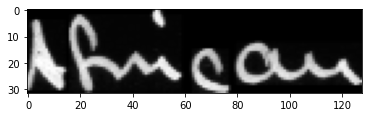



original_text =  National
predicted_text = National

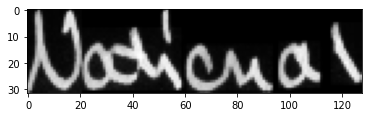



original_text =  (
predicted_text = (

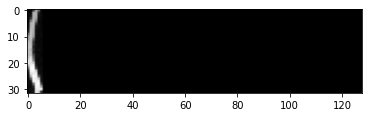



original_text =  400,000
predicted_text = 400,000

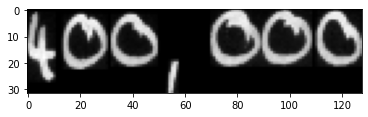



original_text =  )
predicted_text = )

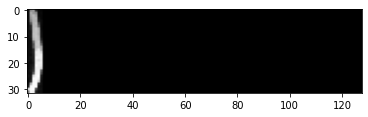



original_text =  will
predicted_text = will

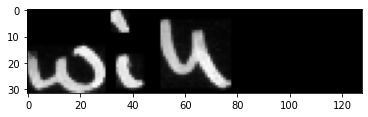



original_text =  meet
predicted_text = meet

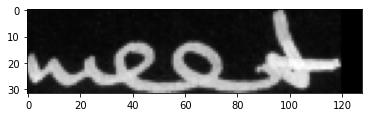



original_text =  in
predicted_text = in

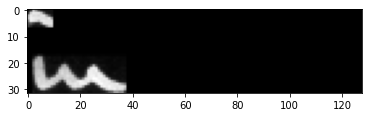



original_text =  London
predicted_text = London

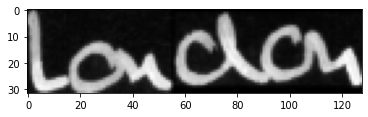



original_text =  today
predicted_text = today

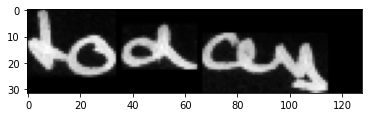



original_text =  to
predicted_text = to

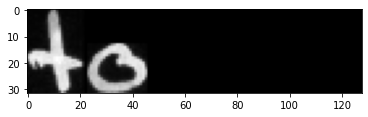



original_text =  a
predicted_text = a

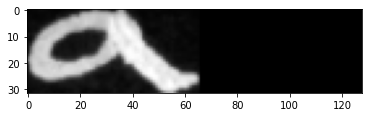



original_text =  common
predicted_text = common

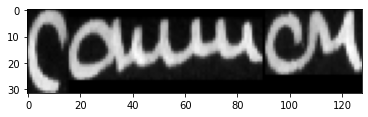



original_text =  course
predicted_text = course

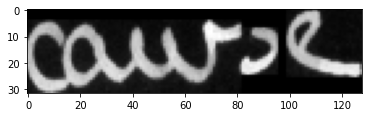

In [ ]:
# predict outputs on validation images
prediction =act_model.predict(train_images[492:525])

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text = ", train_original_text[492+i])
    print("predicted_text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[492+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

## **Plot Accuracy and Loss**

In [ ]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

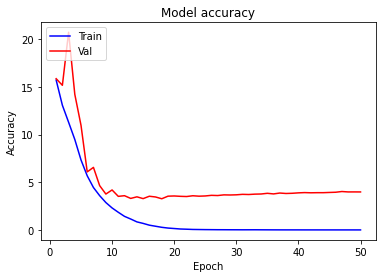

In [ ]:
plotgraph(epochs, loss, val_loss)

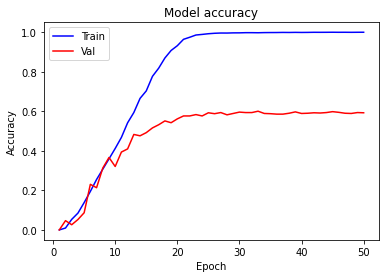

In [ ]:
plotgraph(epochs, acc, val_acc)

# **Get Best Model Index**

In [ ]:
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [ ]:
with open('gdrive/My Drive/Handwritten_text_project_model/history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath,
                                                      optimizer_name,
                                                      str(RECORDS_COUNT),
                                                      e,
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]),
                                                      best_loss,
                                                      best_acc,
                                                      best_val_loss,
                                                      best_val_acc)
    f.write(new_data)

# **Save the Model**

In [ ]:
model.save('gdrive/My Drive/Handwritten_text_project_model/Model.h5')